In [ ]:
!pip install geopandas shapely geopy pyproj folium contextily

In [ ]:
!pip install h3

In [ ]:
# Imports
# Geometry
from h3 import h3
from shapely.geometry import Point
from shapely.geometry import Polygon
from geopy.distance import distance
from geopy.distance import geodesic
from shapely.wkt import loads


# Visualization
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Patch
from matplotlib.lines import Line2D
from matplotlib.collections import PatchCollection
import folium
from IPython.display import display
import contextily as ctx

# Projections
import pyproj
from pyproj import CRS, Transformer

# Data handling
import geopandas as gpd
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
import ast
from pandas.io.json import json_normalize

# Network
import requests
import time

In [ ]:
# Shape files read and set projection
labota_shp = gpd.read_file("your_path/LaBota.shp")
if labota_shp.crs is None:
    labota_shp.crs = 'epsg:32717'
labota_shp = labota_shp.to_crs('epsg:4326')

toctiuco_shp = gpd.read_file("your_path/Toctiuco.shp")
if toctiuco_shp.crs is None:
    toctiuco_shp.crs = 'epsg:32717'
toctiuco_shp = toctiuco_shp.to_crs('epsg:4326')

In [ ]:
labota_shp.head(2)

,OBJECTID,DPA_MANZAN,censo_2010,censo_20_1,censo_20_6,censo_20_7,censo_20_8,censo_20_9,censo_2011,censo_2012,...,censo_2101,censo_2102,censo_2103,censo_2104,CMP1,CMP2,CENSO,AREA,DENSIDAD,geometry
0,33318,17015503900910,PICHINCHA,QUITO,10,7,17,0,0,2,...,0,0,5,5,0,0,17,2.5661,7,"POLYGON ((-78.44785 -0.12192, -78.44787 -0.121..."
1,33429,17015504200101,PICHINCHA,QUITO,27,32,59,3,3,3,...,0,0,0,18,3,3,59,1.7567,34,"POLYGON ((-78.45905 -0.11416, -78.45910 -0.114..."


In [ ]:
# Extract the bounding box of the labota_shp
bbox_bota = labota_shp.total_bounds
polygon_bota = Polygon([(bbox_bota[0], bbox_bota[1]), (bbox_bota[0], bbox_bota[3]), (bbox_bota[2], bbox_bota[3]), (bbox_bota[2], bbox_bota[1])])
# Get the centroid of the bounding box
centroid_bota = polygon_bota.centroid
# Print the centroid coordinates
print(centroid_bota.x, centroid_bota.y)

-78.45956887257326 -0.11562405304648693


In [ ]:
toctiuco_shp.head(2)

,OBJECTID,DPA_MANZAN,censo_2010,censo_20_1,censo_20_6,censo_20_7,censo_20_8,censo_20_9,censo_2011,censo_2012,...,censo_2101,censo_2102,censo_2103,censo_2104,CMP1,CMP2,AREA,TOTAL,DENSIDAD,geometry
0,49163,17015023000104,PICHINCHA,QUITO,22,28,50,2,6,3,...,9,0,0,13,2,6,1.2185,50,41,"POLYGON ((-78.52825 -0.21284, -78.52810 -0.212..."
1,49165,17015023000103,PICHINCHA,QUITO,12,12,24,0,0,2,...,0,0,0,5,0,0,2.1069,24,11,"POLYGON ((-78.52843 -0.21256, -78.52843 -0.212..."


In [ ]:
# Extract the bounding box of the labota_shp
bbox_toctiuco = toctiuco_shp.total_bounds
polygon_toctiuco = Polygon([(bbox_toctiuco[0], bbox_toctiuco[1]), (bbox_toctiuco[0], bbox_toctiuco[3]), (bbox_toctiuco[2], bbox_toctiuco[3]), (bbox_toctiuco[2], bbox_toctiuco[1])])
# Get the centroid of the bounding box
centroid_toctiuco = polygon_toctiuco.centroid
# Print the centroid coordinates
print(centroid_toctiuco.x, centroid_toctiuco.y)

-78.52568864705847 -0.20985476660321467


In [ ]:
polygon1 = {
'type': 'Polygon',
'coordinates': [
[
[bbox_bota[1], bbox_bota[0]],
[bbox_bota[1], bbox_bota[2]],
[bbox_bota[3], bbox_bota[2]],
[bbox_bota[3], bbox_bota[0]],
[bbox_bota[1], bbox_bota[0]]
]
]
}

resolution = 10
hexagons1 = h3.polyfill(polygon1, resolution, geo_json_conformant=False)
hexagons1_list = list(hexagons1)

polygon2 = {
'type': 'Polygon',
'coordinates': [
[
[bbox_toctiuco[1], bbox_toctiuco[0]],
[bbox_toctiuco[1], bbox_toctiuco[2]],
[bbox_toctiuco[3], bbox_toctiuco[2]],
[bbox_toctiuco[3], bbox_toctiuco[0]],
[bbox_toctiuco[1], bbox_toctiuco[0]]
]
]
}

resolution = 10
hexagons2 = h3.polyfill(polygon2, resolution, geo_json_conformant=False)
hexagons2_list = list(hexagons2)



polygonise = lambda hex_id: Polygon(
                                h3.h3_to_geo_boundary(
                                    hex_id, geo_json=True)
                                    )

all_polys1 = gpd.GeoSeries(list(map(polygonise, hexagons1)), \
                                      index=hexagons1, \
                                      crs="EPSG:4326" \
                                     )

all_polys2 = gpd.GeoSeries(list(map(polygonise, hexagons2)), \
                                      index=hexagons2, \
                                      crs="EPSG:4326" \
                                     )

In [ ]:
# Spatial join the H3 layers and the shapefiles
all_polys1_gdf = all_polys1.to_frame()
LaBota_H3 = gpd.sjoin( all_polys1_gdf, labota_shp, op='intersects').reset_index()
LaBota_H3 = LaBota_H3.drop_duplicates(subset='index')
all_polys2_gdf = all_polys2.to_frame()
Toctiuco_H3 = gpd.sjoin( all_polys2_gdf, toctiuco_shp, op='intersects').reset_index()
Toctiuco_H3 = Toctiuco_H3.drop_duplicates(subset='index')

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):
/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [ ]:
# Maps boundaries
def bounding_box_mercator(lat, lon, radius):
    # Define coordinate systems
    wgs84 = CRS("EPSG:4326")  # WGS84
    web_mercator = CRS("EPSG:3857")  # Web Mercator

    # Define transformer
    transformer = Transformer.from_crs(wgs84, web_mercator)

    # Transform lat lon to Web Mercator
    lon_mercator, lat_mercator = transformer.transform(lat, lon)

    # Add/subtract the radius from the projected point
    min_lat = lat_mercator - radius
    max_lat = lat_mercator + radius
    min_lon = lon_mercator - radius
    max_lon = lon_mercator + radius

    return min_lat, min_lon, max_lat, max_lon

# La bota
lat_centroid_bota = centroid_bota.y
lon_centroid_bota = centroid_bota.x
# Toctiuco
lat_centroid_toctiuco = centroid_toctiuco.y
lon_centroid_toctiuco = centroid_toctiuco.x
# Radius
radius = 1400  # meters

min_lat_BOTA, min_lon_BOTA, max_lat_BOTA, max_lon_BOTA = bounding_box_mercator(lat_centroid_bota, lon_centroid_bota, radius)
min_lat_TOC, min_lon_TOC, max_lat_TOC, max_lon_TOC = bounding_box_mercator(lat_centroid_toctiuco, lon_centroid_toctiuco, radius)

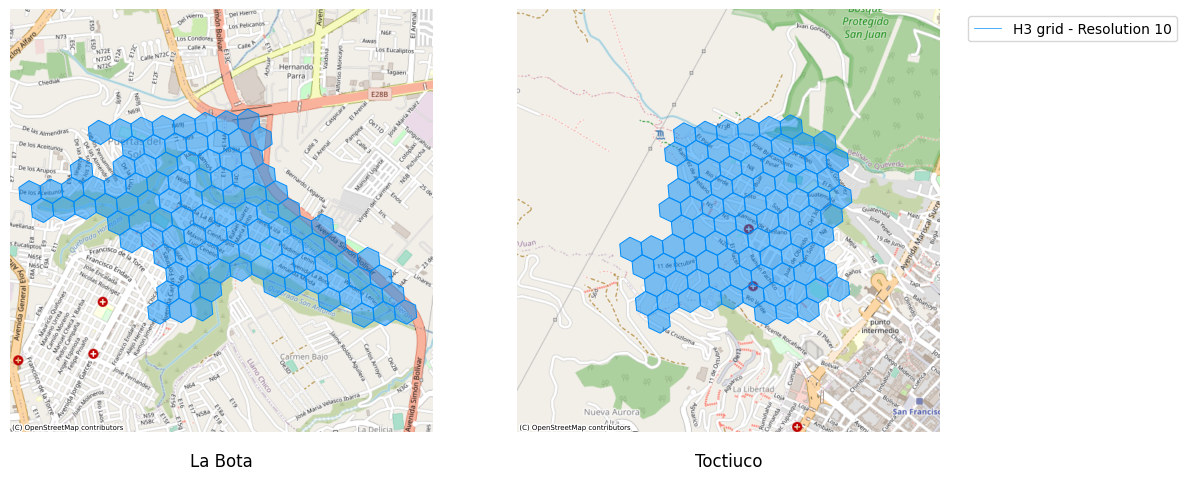

In [ ]:
# Convert geodataframe to Web Mercator (epsg:3857)
LaBota_H3.crs = "EPSG:4326"
LaBota_H32 = LaBota_H3.to_crs(epsg=3857)
Toctiuco_H3.crs = "EPSG:4326"
Toctiuco_H32 = Toctiuco_H3.to_crs(epsg=3857)
# Define the transformer from WGS84 to Web Mercator
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857")

# Create the first subplot
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Subplot 1
ax = axs[0]

# Set the x and y axis limits
ax.set_xlim(min_lon_BOTA, max_lon_BOTA)
ax.set_ylim(min_lat_BOTA, max_lat_BOTA)

# Plot the data (only boundaries in this case)
LaBota_H32.boundary.plot(ax=ax, color='#008BF8', linewidth=0.7)
LaBota_H32.plot(ax=ax, color='#008BF8', linewidth=0.7, alpha=0.5)

# Add basemap with contextily
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, attribution_size=5)

# Get the updated x and y axis limits after adding the basemap
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.axis([xmin, xmax, ymin, ymax])

# Remove the axis
ax.axis('off')
ax.set_title('La Bota', loc='center', y=-0.1)

ax = axs[1]

# Set the x and y axis limits
ax.set_xlim(min_lon_TOC, max_lon_TOC)
ax.set_ylim(min_lat_TOC, max_lat_TOC)

# Plot the data (only boundaries in this case)
Toctiuco_H32.boundary.plot(ax=ax, color='#008BF8', linewidth=0.7)
Toctiuco_H32.plot(ax=ax, color='#008BF8', linewidth=0.7, alpha=0.5)

# Add basemap with contextily
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, attribution_size=5)

# Get the updated x and y axis limits after adding the basemap
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.axis([xmin, xmax, ymin, ymax])

# Remove the axis
ax.axis('off')
ax.set_title('Toctiuco', loc='center', y=-0.1)

# Create a list of legend elements
legend_elements = [
        Line2D([0], [0], color='#008BF8', lw=0.5, label='H3 grid - Resolution 10')
]

# Create the legend
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=10)

In [ ]:
# Save the figure in 300 dpi with tiff format
fig.savefig('your_path/H3.tiff', dpi=300, format='tiff', bbox_inches='tight')
fig.savefig('your_path/H3.jpg', dpi=300, format='jpeg', bbox_inches='tight')